# What is RAG?

RAG stands for Retrieval Augmented Generation.

It was introduced in the paper [*Retrieval-Augmented Generation for Knowledge-Intensive NLP Tasks*](https://arxiv.org/abs/2005.11401).

Each step can be roughly broken down to:

* **Retrieval** - Seeking relevant information from a source given a query. For example, getting relevant passages of Wikipedia text from a database given a question.
* **Augmented** - Using the relevant retrieved information to modify an input to a generative model (e.g. an LLM).
* **Generation** - Generating an output given an input. For example, in the case of an LLM, generating a passage of text given an input prompt.

In [1]:
!git clone https://github.com/Shaheer04/Pak-Tax-Agent.git

Cloning into 'Pak-Tax-Agent'...
remote: Enumerating objects: 59, done.
remote: Counting objects: 100% (59/59), done.
remote: Compressing objects: 100% (38/38), done.
remote: Total 59 (delta 29), reused 40 (delta 15), pack-reused 0
Unpacking objects: 100% (59/59), 1.55 MiB | 3.45 MiB/s, done.


In [2]:
cd Pak-Tax-Agent

/kaggle/working/Pak-Tax-Agent


In [3]:
!python -m venv venv

In [4]:
!pip install -r requirements.txt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.6/57.6 kB 2.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130.7/130.7 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.4/4.4 MB 47.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 84.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.6/62.6 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 156.5/156.5 kB 10.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.3/78.3 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.5/8.5 MB 65.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 779.1/779.1 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 77.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 65.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/8

In [5]:
!pip3 install -U torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121


Looking in indexes: https://download.pytorch.org/whl/cu121
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 781.0/781.0 MB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 5.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 2.6 MB/s eta 0:00:00
  Attempting uninstall: torch
    Found existing installation: torch 2.3.1
    Uninstalling torch-2.3.1:
      Successfully uninstalled torch-2.3.1
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.16.2
    Uninstalling torchvision-0.16.2:
      Successfully uninstalled torchvision-0.16.2
  Attempting uninstall: torchaudio
    Found existing installation: torchaudio 2.1.2
    Uninstalling torchaudio-2.1.2:
      Successfully uninstalled torchaudio-2.1.2


### A local RAG pipeline from scratch

In [6]:
import fitz
from tqdm.auto import tqdm
pdf1_path = "/kaggle/input/pdfs-for-tax-agent/Budget_Brief_2024.pdf"
pdf2_path = "/kaggle/input/pdfs-for-tax-agent/Finance-Bill-2024.pdf"
pdf3_path = "/kaggle/input/pdfs-for-tax-agent/Budget_in_Brief.pdf"
doc_a = fitz.open(pdf1_path)
doc_b = fitz.open(pdf2_path)
doc_c = fitz.open(pdf3_path)
doc_a.insert_pdf(doc_b)
doc_a.insert_pdf(doc_c)
doc_a.save("main.pdf")
pdf_path = "main.pdf"

def text_formatter(text : str) -> str:
    """Performs minor formatting on text. """
    cleaned_text = text.replace("\n", "").strip()
    
    return cleaned_text



def open_and_read_pdf(pdf_path: str) -> list[dict]:
    doc = fitz.open(pdf_path)
    pages_and_texts = []
    for page_number, page in tqdm(enumerate(doc)):
        text = page.get_text()
        text = text_formatter(text=text)
        pages_and_texts.append({"page_number":page_number,
                               "page_char_count":len(text),
                              "page_word_count": len(text.split(" ")),
                              "page_sentence_count_raw": len(text.split(". ")),
                              "page_token_count": len(text)/4, # 1 token = ~4 characters
                               "text": text
                              })
    return pages_and_texts

pdf = open_and_read_pdf(pdf_path=pdf_path)
pages_and_texts = pdf
pages_and_texts[160]

0it [00:00, ?it/s]

{'page_number': 160,
 'page_char_count': 927,
 'page_word_count': 172,
 'page_sentence_count_raw': 9,
 'page_token_count': 231.75,
 'text': '119  TABLE S. No. Fair Market Value of Immovable Property Tax Rate  (1) (2) (3) 1 Where the fair market value does not exceed Rs. 50 million 6% 2 Where the fair market value exceeds Rs. 50 million but does not exceed Rs. 100 million 7% 3 Where the fair market value exceeds Rs. 100 million  8% ; and (c)  in rule 10, after the omitted sub-rule (x), the following new sub-rule shall be added, namely: – “(y) tax collected under section 37A.”. 7. Amendments of the Federal Excise Act, 2005.— In the Federal Excise Act, 2005, the following further amendments shall be made, namely: - (1) in section 8, for the word “twelve”, the words “KIBOR plus three” shall be substituted; (2) in section 19,– (a) in sub-section (3),– (i) in clause (d), the word “and”, at the end shall be omitted;  (ii) in clause (e), after the expression “under;” the word “and” shall be ad

In [7]:
import random
random.sample(pages_and_texts, k=2)

[{'page_number': 200,
  'page_char_count': 978,
  'page_word_count': 112,
  'page_sentence_count_raw': 4,
  'page_token_count': 244.5,
  'text': 'Budget RevisedBudget2023-242023-242024-25116,33516,33510,0002222225320,00019,25540,0004332332340516516516563131317--35,000810,00010,0003,500921,01521,01521,0001046946969411--65612--3,30068,36967,624114,711Loans/Adv ances to Friendly  CountriesClassificationWay s & Means Adv ances to the Gov t.ofAJK f or repay ment ofprincipal &interestTable-14 shows Current Loans & Adv ancesas prov ided by Federal Gov ernment toGov ts. of AJK, GB and v arious institutions as well as Gov t. Serv ants to enable them tomeet their f inancial requirements. The details are as under:  Way s and Means to Prov incesGilgit-Baltistanf orRepay mentofPrincipal and InterestLoans and Adv ancesto Gov ernmentsServ antsCURRENT LOANS & ADVANCESTOTAL:Loans to Pakistan Steel Mills KarachiOthers Junagadh and Kathiawar Chief sLoantoPakistanCentralCottonCommittee (PCCC)(Rs in Millio

In [8]:
import pandas as pd

df = pd.DataFrame(pages_and_texts)
df

page_number  page_char_count  page_word_count  page_sentence_count_raw  \
0              0               84               10                        1   
1              1             2194              363                        8   
2              2              389               49                        2   
3              3             3760              551                        6   
4              4             3808              573                       15   
..           ...              ...              ...                      ...   
201          201             1477              206                        5   
202          202             1353              167                        3   
203          203             1340              114                        3   
204          204              547               33                        1   
205          205              826              268                        1   

     page_token_count                                               text  
0               21.00  Budget Brief 202413 June 2024home.kpmg/pkKPMG ...  
1              548.50  Preamble2The Finance Bill, 2024 has been prese...  
2               97.25  Contents© 2024  KPMG Taseer Hadi & Co., a Part...  
3              940.00  Budget Brief 2024   | 1 © 2024 KPMG Taseer Had...  
4              952.00  Budget Brief 2024   | 2© 2024 KPMG Taseer Hadi...  
..                ...                                                ...  
201            369.25  Budget RevisedBudget2023-242023-242024-2511001...  
202            338.25  BudgetRevisedBudget2023-242023-242024-25652,95...  
203            335.00  Budget RevisedBudget2023-242023-242024-25162,0...  
204            136.75  Budget RevisedBudget2023-242023-242024-25B.212...  
205            206.50  Budget RevisedBudget2023-242023-242024-2524,35...  

[206 rows x 6 columns]

In [9]:
df.describe()

page_number  page_char_count  page_word_count  page_sentence_count_raw  \
count   206.000000       206.000000       206.000000               206.000000   
mean    102.500000      1394.344660       227.553398                 7.587379   
std      59.611241      1035.124606       172.840585                 9.397438   
min       0.000000         0.000000         1.000000                 1.000000   
25%      51.250000       739.000000       113.250000                 2.000000   
50%     102.500000      1126.500000       188.500000                 5.000000   
75%     153.750000      1595.500000       260.500000                 9.000000   
max     205.000000      4795.000000       761.000000                85.000000   

       page_token_count  
count        206.000000  
mean         348.586165  
std          258.781151  
min            0.000000  
25%          184.750000  
50%          281.625000  
75%          398.875000  
max         1198.750000

why would we care about token count ?

token count is important to think about because:
1. Embedding models don't deal with infinte tokens
2. LLMs don't deal with infinite tokens either

For example an embedding model may have been trained to embed sequences of 384 tokens into numerical space(sentence tranformers all mpnet base V2).

### Further text preprocessing

two ways to do this:
1.  we can do this by splitting on ". ".
2. we can do this by using NLP libraries such as spacy and nltk.

In [10]:
from spacy.lang.en import English

nlp = English()

#Add a sentencizer pipeline of Spacy
nlp.add_pipe("sentencizer")

doc = nlp("This is a sentence. this is another sentence. I like elephants.")
assert len(list(doc.sents)) == 3

list(doc.sents)

[This is a sentence., this is another sentence., I like elephants.]

In [11]:
pages_and_texts[0]

{'page_number': 0,
 'page_char_count': 84,
 'page_word_count': 10,
 'page_sentence_count_raw': 1,
 'page_token_count': 21.0,
 'text': 'Budget Brief 202413 June 2024home.kpmg/pkKPMG Taseer Hadi & Co.Chartered Accountants'}

In [12]:
for item in tqdm(pages_and_texts):
    item["sentences"] = list(nlp(item["text"]).sents)
    
    # Make sure all sentences are strings (the default type is spacy datatype)
    
    item["sentences"] = [str(sentence) for sentence in item["sentences"]]
    
    # count the sentences
    item["page_sentence_count_spacy"] = len(item["sentences"])

  0%|          | 0/206 [00:00<?, ?it/s]

In [13]:
random.sample(pages_and_texts, k=1)

[{'page_number': 197,
  'page_char_count': 1000,
  'page_word_count': 91,
  'page_sentence_count_raw': 1,
  'page_token_count': 250.0,
  'text': 'Budget RevisedBudget2023-242023-242024-25-100100--2,0002,0003,000-9,00030,0008,600-3,6613,6614,500-1,5001,5001,150-477477500-100100100 - 10010010-1010--3,0003,00040,000-100100--200120--500500----400-8,0008,000--1,0001,000- - 500500--500500--1,0001,000--1,000400--1,000--Nay a Pakistan Certif icates & othersReliefto widow borrowersofHBFCL(Widows Welf are)Ref inance and Credit Guarantee Scheme f or Women EnterpreneursPM Youth Business & Agriculture Loan SchemeGIDC f or ISGSPM Kamy ab Jawan/ YES ProgramPM Youth Business LoanPublicFinancialManagement&Accountability  (Prov inces-P4R)Kamy ab Pakistan Program  Concessional Credit f or Small FarmersContd…PLICFilm Finance FundCredit Guarantee Scheme to SMEs/SMEAsaan FinanceSAP Sy stem Up-gradationClassificationDCS PensionSouth Asian Games-IPC(Rs in Million)Re-Finance Risk Sharing Loan SchemeAgriculture

In [14]:
df = pd.DataFrame(pages_and_texts)
df.describe().round(2)

page_number  page_char_count  page_word_count  page_sentence_count_raw  \
count       206.00           206.00           206.00                   206.00   
mean        102.50          1394.34           227.55                     7.59   
std          59.61          1035.12           172.84                     9.40   
min           0.00             0.00             1.00                     1.00   
25%          51.25           739.00           113.25                     2.00   
50%         102.50          1126.50           188.50                     5.00   
75%         153.75          1595.50           260.50                     9.00   
max         205.00          4795.00           761.00                    85.00   

       page_token_count  page_sentence_count_spacy  
count            206.00                     206.00  
mean             348.59                       7.44  
std              258.78                       8.67  
min                0.00                       0.00  
25%              184.75                       2.00  
50%              281.62                       5.00  
75%              398.88                       9.00  
max             1198.75                      76.00

### Chunking our sentences together

why do we do this:
1. so our texts are easier to filter.

In [15]:
#define split size to turn groups of sentencs into chunks
num_sentences_chunk_size = 10

# Create a function to split texts recursively into chunk size
# eg. [20] -> [10,10]
def split_list(input_list: list[str], slice_size: int=num_sentences_chunk_size) -> list[list[str]]:
    return [input_list[i:i + slice_size] for i in range (0, len(input_list), slice_size)]


test_list = list(range(25))
split_list(test_list)


     

[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
 [10, 11, 12, 13, 14, 15, 16, 17, 18, 19],
 [20, 21, 22, 23, 24]]

In [16]:
# loop through pages and texts and split sentences into chunks

for item in tqdm(pages_and_texts):
    item["sentence_chunks"] = split_list(input_list=item["sentences"],
                                         slice_size=num_sentences_chunk_size)
    item["num_chunks"] = len(item["sentence_chunks"])

  0%|          | 0/206 [00:00<?, ?it/s]

In [17]:
random.sample(pages_and_texts, k=1)

[{'page_number': 42,
  'page_char_count': 1076,
  'page_word_count': 188,
  'page_sentence_count_raw': 8,
  'page_token_count': 269.0,
  'text': '1  A BILL to give effect to the financial proposals of the Federal Government for the year beginning on the first day of July, 2024, and to amend certain laws WHEREAS, it is expedient to make provisions to give effect to the financial proposals of the Federal Government for the year beginning on the first day of July, 2024, and to amend certain laws for the purposes hereinafter appearing; It is hereby enacted as follows: - 1. Short title and commencement. ─ (1) This Bill shall be called the Finance Bill, 2024. (2) It shall, unless otherwise provided, come into force on the first day of July, 2024. 2. Amendment of The Petroleum Products (Petroleum Levy) Ordinance, 1961 (XXV of 1961).— In the Petroleum Products (Petroleum Levy) Ordinance, 1961 (XXV of 1961), for the Fifth Schedule, the following shall be substituted, namely:—  “The Fifth Schedu

In [18]:
df = pd.DataFrame(pages_and_texts)
df.describe().round(2)

page_number  page_char_count  page_word_count  page_sentence_count_raw  \
count       206.00           206.00           206.00                   206.00   
mean        102.50          1394.34           227.55                     7.59   
std          59.61          1035.12           172.84                     9.40   
min           0.00             0.00             1.00                     1.00   
25%          51.25           739.00           113.25                     2.00   
50%         102.50          1126.50           188.50                     5.00   
75%         153.75          1595.50           260.50                     9.00   
max         205.00          4795.00           761.00                    85.00   

       page_token_count  page_sentence_count_spacy  num_chunks  
count            206.00                     206.00      206.00  
mean             348.59                       7.44        1.29  
std              258.78                       8.67        0.81  
min                0.00                       0.00        0.00  
25%              184.75                       2.00        1.00  
50%              281.62                       5.00        1.00  
75%              398.88                       9.00        1.00  
max             1198.75                      76.00        8.00

### Splitting each chunk into its own item

In [19]:
import re

#split each chunk into its own item
pages_and_chunks = []
for item in tqdm(pages_and_texts):
    for sentence_chunk in item["sentence_chunks"]:
        chunk_dict = {}
        chunk_dict["page_number"] = item["page_number"]
        
        #join the sentences together into a paragaraph like structure.
        
        joined_sentence_chunk = "".join(sentence_chunk).replace("  ", " ").strip()
        joined_sentence_chunk = re.sub(r'\.([A-Z])', r'.\1', joined_sentence_chunk)
        chunk_dict["sentence_chunk"] = joined_sentence_chunk
        
        # Get some stats on our chunks
        chunk_dict["chunk_char_count"] = len(joined_sentence_chunk)
        chunk_dict["chunk_word_count"] = len([word for word in joined_sentence_chunk.split(" ")])
        chunk_dict["chunk_token_count"] = len(joined_sentence_chunk) / 4 # 1 token = ~4 chars
    
    
        pages_and_chunks.append(chunk_dict)

        
len(pages_and_chunks)

  0%|          | 0/206 [00:00<?, ?it/s]

265

In [20]:
random.sample(pages_and_chunks, k=1)

[{'page_number': 146,
  'sentence_chunk': '105 contracts entered into by members of Pakistan Mercantile Exchange Provided that for securities except at S. No.8 of the Table– (i) the rate of 12.5% tax shall be charged on capital gain arising on disposal where the securities are acquired on or after the first day of July, 2013 but on or before the 30th day of June, 2022; and (ii) the rate of 0% tax shall be charged on capital gain arising on disposal where the securities are acquired before the first day of July, 2013: Provided further that the rate for companies in respect of debt securities shall be as specified in Division II of Part I of the First Schedule: Provided also that a mutual fund or a collective investment scheme or a REIT scheme shall deduct Capital Gains Tax at the rates as specified below, on redemption of securities as prescribed, namely: —',
  'chunk_char_count': 825,
  'chunk_word_count': 148,
  'chunk_token_count': 206.25}]

In [21]:
df = pd.DataFrame(pages_and_chunks)
df.describe().round(2)

page_number  chunk_char_count  chunk_word_count  chunk_token_count
count       265.00            265.00            265.00             265.00
mean         86.31           1072.84            166.05             268.21
std          62.01            643.29            104.85             160.82
min           0.00              9.00              3.00               2.25
25%          27.00            608.00             84.00             152.00
50%          78.00            994.00            155.00             248.50
75%         141.00           1445.00            234.00             361.25
max         205.00           3983.00            567.00             995.75

In [22]:
df

page_number                                     sentence_chunk  \
0              0  Budget Brief 202413 June 2024home.kpmg/pkKPMG ...   
1              1  Preamble2The Finance Bill, 2024 has been prese...   
2              1                               All rights reserved.   
3              2  Contents© 2024 KPMG Taseer Hadi & Co., a Partn...   
4              3  Budget Brief 2024  | 1 © 2024 KPMG Taseer Hadi...   
..           ...                                                ...   
260          201  Budget RevisedBudget2023-242023-242024-2511001...   
261          202  BudgetRevisedBudget2023-242023-242024-25652,95...   
262          203  Budget RevisedBudget2023-242023-242024-25162,0...   
263          204  Budget RevisedBudget2023-242023-242024-25B.212...   
264          205  Budget RevisedBudget2023-242023-242024-2524,35...   

     chunk_char_count  chunk_word_count  chunk_token_count  
0                  84                10              21.00  
1                2166               353             541.50  
2                  20                 3               5.00  
3                 387                47              96.75  
4                3754               545             938.50  
..                ...               ...                ...  
260              1464               193             366.00  
261              1341               155             335.25  
262              1332               106             333.00  
263               544                30             136.00  
264               710               152             177.50  

[265 rows x 5 columns]

## Embedding our texts chunks


Embedding is a powerful concept.
while humans understand text, machines understand numbers.

Embedding is a useful numerical representation of a text.

the best part about embeddings is that are a 'Learned' representation.

{
'the' " 0,

'a': 1
}

for more information on embedding check out : 

In [23]:
from sentence_transformers import SentenceTransformer

embedding_model = SentenceTransformer(model_name_or_path="all-mpnet-base-v2",
                                     device="cpu")

#create a list of sentence to try
sentences = ["the sentence transformer library provides an easy way to create embeddings.",
             "Sentences can be embedded one by one or in a list",
             "I like horses!"]
    
# Sentences are encoded/ embedded by calling model.encode().

embeddings = embedding_model.encode(sentences)
embeddings_dict = dict(zip(sentences,embeddings))

#see the embeddings
for sentence, embedding in embeddings_dict.items():
    print(f"Sentence:{sentence}")
    print(f"Embedding:{embedding}")
    print("")

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.6k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Sentence:the sentence transformer library provides an easy way to create embeddings.
Embedding:[-3.44286114e-02  2.95328423e-02 -2.33643372e-02  5.57256751e-02
 -2.19097994e-02 -6.47055497e-03  1.02849230e-02 -6.57803342e-02
  2.29717847e-02 -2.61120778e-02  3.80421244e-02  5.61402477e-02
 -3.68746147e-02  1.52787883e-02  4.37021255e-02 -5.19723296e-02
  4.89479341e-02  3.58104706e-03 -1.29750641e-02  3.54383281e-03
  4.23262045e-02  3.52606140e-02  2.49402113e-02  2.99177356e-02
 -1.99381411e-02 -2.39752606e-02 -3.33371013e-03 -4.30449396e-02
  5.72014377e-02 -1.32517694e-02 -3.54478322e-02 -1.13936430e-02
  5.55561818e-02  3.61099397e-03  8.88526984e-07  1.14027616e-02
 -3.82229984e-02 -2.43542180e-03  1.51313767e-02 -1.32599045e-04
  5.00659198e-02 -5.50877117e-02  1.73444636e-02  5.00959121e-02
 -3.75959650e-02 -1.04463799e-02  5.08322231e-02  1.24860713e-02
  8.67377594e-02  4.64143306e-02 -2.10690200e-02 -3.90251726e-02
  1.99692417e-03 -1.42345652e-02 -1.86795574e-02  2.82669757

In [24]:
embeddings[0].shape

(768,)

In [25]:
embedding = embedding_model.encode("My favourite animal is the cow")
embedding

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

array([-8.87766201e-03,  8.35835487e-02, -2.81862989e-02, -3.71654667e-02,
        2.18684021e-02,  5.61196655e-02, -7.55761042e-02,  1.01798950e-02,
        1.48691563e-02, -2.08466426e-02, -2.89395861e-02,  4.55776677e-02,
       -3.03733051e-02, -1.41893951e-02, -1.61682852e-02, -3.85182723e-02,
        3.52857895e-02,  5.25920466e-03, -2.22115330e-02,  3.23854685e-02,
       -2.36056410e-02,  4.16592732e-02, -1.16741108e-02, -2.24949829e-02,
       -1.69876181e-02,  8.03114846e-03, -3.82861751e-03, -2.72515286e-02,
        2.71817297e-02,  2.64697801e-02, -6.16850220e-02, -8.03408995e-02,
        2.93563325e-02, -2.60433685e-02,  1.26088582e-06,  7.68711511e-03,
       -2.78717596e-02,  5.80591848e-03,  4.93112244e-02, -4.50259959e-03,
        3.92274559e-03,  1.44862086e-02, -1.33294631e-02,  1.35614341e-02,
        1.89375449e-02,  6.01764694e-02,  4.52522896e-02,  1.80459730e-02,
       -9.52361971e-02,  2.16227397e-02, -3.90323973e-03, -2.29934324e-02,
       -3.01052202e-02, -

In [26]:
!nvcc --version

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2023 NVIDIA Corporation
Built on Mon_Apr__3_17:16:06_PDT_2023
Cuda compilation tools, release 12.1, V12.1.105
Build cuda_12.1.r12.1/compiler.32688072_0


%%time
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Device : {device}")
embedding_model.to(device)

for item in tqdm(pages_and_chunks):
    item['embedding'] = embedding_model.encode(item["sentence_chunk"])

In [27]:
%%time
# Send the model to the CPU
embedding_model.to("cpu")

# Create embeddings one by one on the GPU
for item in tqdm(pages_and_chunks):
    item["embedding"] = embedding_model.encode(item["sentence_chunk"])

  0%|          | 0/265 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

CPU times: user 2min 31s, sys: 8.42 s, total: 2min 39s
Wall time: 1min 20s


In [28]:
pages_and_chunks

[{'page_number': 0,
  'sentence_chunk': 'Budget Brief 202413 June 2024home.kpmg/pkKPMG Taseer Hadi & Co.Chartered Accountants',
  'chunk_char_count': 84,
  'chunk_word_count': 10,
  'chunk_token_count': 21.0,
  'embedding': array([ 2.52625253e-03,  1.06579333e-03, -1.85188595e-02,  1.42289763e-02,
         -2.97652818e-02, -1.75089873e-02,  5.64480294e-03,  1.12263756e-02,
         -2.93973256e-02,  2.38025244e-02,  2.90868175e-03,  2.36894414e-02,
          6.00418001e-02,  7.51313940e-02,  2.72834916e-02, -7.26793706e-02,
          3.40145044e-02, -1.68956481e-02, -1.02172397e-01, -1.31015927e-02,
         -1.98428854e-02,  1.21643441e-02, -1.57126896e-02,  2.97874939e-02,
         -1.58071648e-02,  1.03169065e-02, -2.78731342e-02, -2.97985431e-02,
         -1.65183060e-02, -1.72791425e-02,  7.16258213e-02,  1.65752862e-02,
          9.39093065e-03, -3.71757336e-02,  1.94713152e-06, -2.50581875e-02,
         -2.50992905e-02, -1.04882233e-02, -4.38384153e-02,  6.81649521e-02,
        

In [29]:
# Turn text chunks into a single list
text_chunks = [item["sentence_chunk"] for item in pages_and_chunks]

In [30]:
embedding_model.to("cuda")

SentenceTransformer(
  (0): Transformer({'max_seq_length': 384, 'do_lower_case': False}) with Transformer model: MPNetModel 
  (1): Pooling({'word_embedding_dimension': 768, 'pooling_mode_cls_token': False, 'pooling_mode_mean_tokens': True, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False, 'pooling_mode_weightedmean_tokens': False, 'pooling_mode_lasttoken': False, 'include_prompt': True})
  (2): Normalize()
)

In [31]:
%%time

# Embed all texts in batches
text_chunk_embeddings = embedding_model.encode(text_chunks,
                                                batch_size=32, #reduce this if GPU has low VRAM
                                               convert_to_tensor = True)

text_chunk_embeddings

Batches:   0%|          | 0/9 [00:00<?, ?it/s]

CPU times: user 3.3 s, sys: 103 ms, total: 3.4 s
Wall time: 3.1 s


tensor([[ 0.0025,  0.0011, -0.0185,  ...,  0.0514, -0.0755, -0.0137],
        [-0.0333,  0.0326, -0.0285,  ...,  0.0145, -0.0615,  0.0018],
        [ 0.0606,  0.0522,  0.0297,  ..., -0.0288,  0.0297, -0.0193],
        ...,
        [ 0.0334,  0.0467, -0.0168,  ...,  0.0014, -0.0305, -0.0280],
        [-0.0008,  0.0745, -0.0129,  ..., -0.0408, -0.0589, -0.0048],
        [-0.0216,  0.1065, -0.0036,  ..., -0.0186, -0.0110,  0.0115]],
       device='cuda:0')

In [32]:
pages_and_chunks[32]

{'page_number': 16,
 'sentence_chunk': '800,000 1,200,001 to 1,600,000 Rs.75,000 plus 20% of the amount exceeding Rs.1,200,000 Rs.90,000 plus 20% of the amount exceeding Rs.1,200,000 1,600,001 to 2,400,000 Rs.170,000 plus 30% of the amount exceeding Rs.1,600,000 2,400,001 to 3,000,000 Rs.315,000 plus 25% of the amount exceeding Rs.2,400,000 3,000,001 to 3,200,000 Rs.465,000 plus 30% of the amount exceeding Rs.3,000,000 3,200,001 to 4,000,000 Rs.650,000 plus 40% of the amount exceeding Rs.3,200,000 4,000,001 to 5,600,000 Rs.765,000 plus 35% of the amount exceeding Rs.4,000,000 5,600,001 and above Rs.1,610,000 plus 45% of the amount exceeding Rs.5,600,000',
 'chunk_char_count': 621,
 'chunk_word_count': 86,
 'chunk_token_count': 155.25,
 'embedding': array([ 3.96272633e-03, -1.83003061e-02,  5.15821297e-03,  1.81478355e-02,
         2.15498786e-02,  1.35146240e-02, -7.10228272e-03,  4.42640521e-02,
        -1.02268793e-02,  2.91256071e-03, -1.79169849e-02, -1.51746124e-02,
         3.953

In [33]:
# Save embeddings to file

text_chunks_and_embeddings_df = pd.DataFrame(pages_and_chunks)
embeddings_df_save_path = "text_chunks_and_embeddings_df.csv"
text_chunks_and_embeddings_df.to_csv(embeddings_df_save_path, index=False)

In [34]:
# importing and reading the files
file = pd.read_csv("text_chunks_and_embeddings_df.csv")
file.head()

page_number                                     sentence_chunk  \
0            0  Budget Brief 202413 June 2024home.kpmg/pkKPMG ...   
1            1  Preamble2The Finance Bill, 2024 has been prese...   
2            1                               All rights reserved.   
3            2  Contents© 2024 KPMG Taseer Hadi & Co., a Partn...   
4            3  Budget Brief 2024  | 1 © 2024 KPMG Taseer Hadi...   

   chunk_char_count  chunk_word_count  chunk_token_count  \
0                84                10              21.00   
1              2166               353             541.50   
2                20                 3               5.00   
3               387                47              96.75   
4              3754               545             938.50   

                                           embedding  
0  [ 2.52625253e-03  1.06579333e-03 -1.85188595e-...  
1  [-3.32861543e-02  3.25975679e-02 -2.84517631e-...  
2  [ 6.05909675e-02  5.21582477e-02  2.97497306e-...  
3  [ 1.11366564e-04 -1.27126789e-02 -1.27489166e-...  
4  [-6.46219996e-05  3.13259326e-02 -2.13491060e-...

# 2. RAG-Search and Answer


RAG goal: Retrieve relevant passages based on a query and use those passages to augment an input to an LLM so it can generate an output based on those relevant passages.

## Similarity search

Embeddings can be used for almost any type of data.

For example, you can turn images into embeddings

Comparing embeddings is known as similarity search, vector search or semantic search.

In our Case, we want to query our pdf passages based on semantics or "vibe".capitalize
so if I search for tax rebate I should get relevant message to that text but may not contain exactly the words.

whereas with keyword search, if I search "apple" I get back passagesw with specifically "apple".

In [35]:
import random
import torch
import numpy as np
import pandas as pd

device = "cuda" if torch.cuda.is_available() else "cpu"

# import texts and embeddings df
text_and_embeddings_df = pd.read_csv("text_chunks_and_embeddings_df.csv")

# convert embedding column back to numpy array. (it got converted to string when it saved to CSV)
text_and_embeddings_df["embedding"] = text_and_embeddings_df["embedding"].apply(lambda x:np.fromstring(x.strip("[]"), sep=" "))

# Convert embeddings into torch.tensor
embeddings = torch.tensor(np.stack(text_and_embeddings_df["embedding"].to_list(), axis=0), dtype=torch.float32)

# convert texts into embedding df to list of dicts
pages_and_chunks = text_and_embeddings_df.to_dict(orient="records")

text_and_embeddings_df

page_number                                     sentence_chunk  \
0              0  Budget Brief 202413 June 2024home.kpmg/pkKPMG ...   
1              1  Preamble2The Finance Bill, 2024 has been prese...   
2              1                               All rights reserved.   
3              2  Contents© 2024 KPMG Taseer Hadi & Co., a Partn...   
4              3  Budget Brief 2024  | 1 © 2024 KPMG Taseer Hadi...   
..           ...                                                ...   
260          201  Budget RevisedBudget2023-242023-242024-2511001...   
261          202  BudgetRevisedBudget2023-242023-242024-25652,95...   
262          203  Budget RevisedBudget2023-242023-242024-25162,0...   
263          204  Budget RevisedBudget2023-242023-242024-25B.212...   
264          205  Budget RevisedBudget2023-242023-242024-2524,35...   

     chunk_char_count  chunk_word_count  chunk_token_count  \
0                  84                10              21.00   
1                2166               353             541.50   
2                  20                 3               5.00   
3                 387                47              96.75   
4                3754               545             938.50   
..                ...               ...                ...   
260              1464               193             366.00   
261              1341               155             335.25   
262              1332               106             333.00   
263               544                30             136.00   
264               710               152             177.50   

                                             embedding  
0    [0.00252625253, 0.00106579333, -0.0185188595, ...  
1    [-0.0332861543, 0.0325975679, -0.0284517631, 0...  
2    [0.0605909675, 0.0521582477, 0.0297497306, 0.0...  
3    [0.000111366564, -0.0127126789, -0.0127489166,...  
4    [-6.46219996e-05, 0.0313259326, -0.021349106, ...  
..                                                 ...  
260  [-0.0221968908, 0.0220334195, -0.0414570272, 0...  
261  [-0.0353536084, 0.0364837907, -0.0223181341, 0...  
262  [0.0334442519, 0.0467160195, -0.0167514738, -0...  
263  [-0.000822944741, 0.0745335892, -0.012868938, ...  
264  [-0.0216362607, 0.106461018, -0.00363263558, -...  

[265 rows x 6 columns]

In [36]:
text_and_embeddings_df["embedding"]

0      [0.00252625253, 0.00106579333, -0.0185188595, ...
1      [-0.0332861543, 0.0325975679, -0.0284517631, 0...
2      [0.0605909675, 0.0521582477, 0.0297497306, 0.0...
3      [0.000111366564, -0.0127126789, -0.0127489166,...
4      [-6.46219996e-05, 0.0313259326, -0.021349106, ...
                             ...                        
260    [-0.0221968908, 0.0220334195, -0.0414570272, 0...
261    [-0.0353536084, 0.0364837907, -0.0223181341, 0...
262    [0.0334442519, 0.0467160195, -0.0167514738, -0...
263    [-0.000822944741, 0.0745335892, -0.012868938, ...
264    [-0.0216362607, 0.106461018, -0.00363263558, -...
Name: embedding, Length: 265, dtype: object

In [37]:
embeddings.shape

torch.Size([265, 768])

In [38]:
# Create embedding model

from sentence_transformers import util,SentenceTransformer

embedding_model = SentenceTransformer(model_name_or_path="all-mpnet-base-v2",
                                     device="cpu")


/opt/conda/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


### Embedding model ready

lets create a small semantic search pipeline.

In essence, we want to search for a query (e.g. "tax rebate") and get back relevant passages from our textbooks

we can do so with following steps:
1. Define a query string
2. turn the query string into embedding.
3. Perform a dot product or cosine similarity fucntion between the text embedding and query embedding
4. Sort the results from 3 in descending order.

Note : to use dot product for comparison, ensure vector sizes are of same shape(eg: 768) and tensors/vectors are of same datatype (eg: both should be torch.float32)

In [39]:
# Define the query

query = "tax on property"
print(f"Query: {query}")

# Embed the query 
# Note : its important to embed your query with the same model you use for embedding the data.
query_embedding = embedding_model.encode(query, convert_to_tensor=True)

#Get similarity scores with the dot product (use cosine similarity if outputs of model aren't normalized)
from time import perf_counter as timer

start_time = timer()
dot_scores = util.dot_score(a=query_embedding,b=embeddings)[0]
end_time = timer()

print(f"[INFO] Time taken to get scores on {len(embeddings)} embeddings:{end_time-start_time:.5f}seconds.")


# Get the top K results ( means top 5)
top_results_dot_product = torch.topk(dot_scores, k=5)
top_results_dot_product


Query: tax on property


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

[INFO] Time taken to get scores on 265 embeddings:0.00050seconds.


torch.return_types.topk(
values=tensor([0.6349, 0.6114, 0.5738, 0.5442, 0.5290]),
indices=tensor([209, 220, 208,  36, 214]))

In [40]:
pages_and_chunks[201]

{'page_number': 142,
 'sentence_chunk': 'Where taxable income exceeds Rs.2,200,000 but does not exceed Rs.3,200,000 Rs.180,000 + 25% of the amount exceeding Rs.2,200,000 5.Where taxable income exceeds Rs.3,200,000 but does not exceed Rs.4,100,000 Rs.430,000 + 30% of the amount exceeding Rs.3,200,000 6.',
 'chunk_char_count': 262,
 'chunk_word_count': 37,
 'chunk_token_count': 65.5,
 'embedding': array([-1.95620283e-02, -5.18708453e-02,  3.58581566e-03,  1.48007525e-02,
        -2.00134460e-02, -1.82488356e-02, -1.30050303e-02,  2.49139778e-02,
         3.21800597e-02, -1.64483674e-02,  9.41182114e-03,  2.07211263e-02,
         1.99863743e-02,  2.85530165e-02,  1.44108244e-05, -1.02267321e-02,
         9.39534791e-03,  1.77781936e-03, -5.71244285e-02,  3.63984355e-03,
        -2.02992596e-02,  4.95944172e-03, -4.59779501e-02,  2.12599710e-02,
         2.18892749e-02,  1.87183525e-02,  1.44661414e-02, -2.04288512e-02,
        -4.01734225e-02,  1.20297698e-02, -8.05984717e-03,  4.68076356

That means we can get pretty far by just storing our embeddings in torch.tensor for now.

However, for much larger datasets, we'd likely look at a dedicated vector database/indexing libraries such as Faiss.

lets make our search results pretty

In [41]:
import textwrap

def print_wrapped(text, wrap_length=80):
    wrapped_text= textwrap.fill(text, wrap_length)
    print(wrapped_text)

In [42]:
query = "tax on salaried class"
print(f"Query:{query}\n")
print("Results: ")
# Loop through together scores and indices from torch.topk
for score, idx in zip(top_results_dot_product[0], top_results_dot_product[1]):
    print(f"Score: {score}")
    print("Text :")
    print_wrapped(pages_and_chunks[idx]["sentence_chunk"])
    print(f"Page number : {pages_and_chunks[idx]['page_number']}")
    print("\n")

Query:tax on salaried class

Results: 
Score: 0.6349382996559143
Text :
108 3.Where the holding period exceeds two years but does not exceed three years
10% 7.5% 0 appearing on the Active Taxpayers’ List on the date of disposal of
property:  Provided that the rate of tax for individuals and association of
persons not appearing on the Active Taxpayers’ List on the date of disposal, the
rate of tax shall not be less than 15% of the gain.”;4.Where the holding period
exceeds three years but does not exceed four years 7.5% 5% -
Page number : 149


Score: 0.6113529801368713
Text :
119 TABLE S. No.Fair Market Value of Immovable Property Tax Rate (1) (2) (3) 1
Where the fair market value does not exceed Rs.50 million 6% 2 Where the fair
market value exceeds Rs.50 million but does not exceed Rs.100 million 7% 3 Where
the fair market value exceeds Rs.100 million 8% ; and (c) in rule 10, after the
omitted sub-rule (x), the following new sub-rule shall be added, namely: – “(y)
tax collected under 

### Note: 

We could potentially improve the order of these results with a reranking model. A model that has been trained specifically to take search results.

(e.g : the top 25 semantic search results) and rank rank them in order from most likely to least likely.

for this we can use **Mixbread Rerank model**

To check our results, what if we wanted to automatically surface the page of texts related to our query?

### Optional Page image extractor

In [43]:
!pip install matplotlib

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


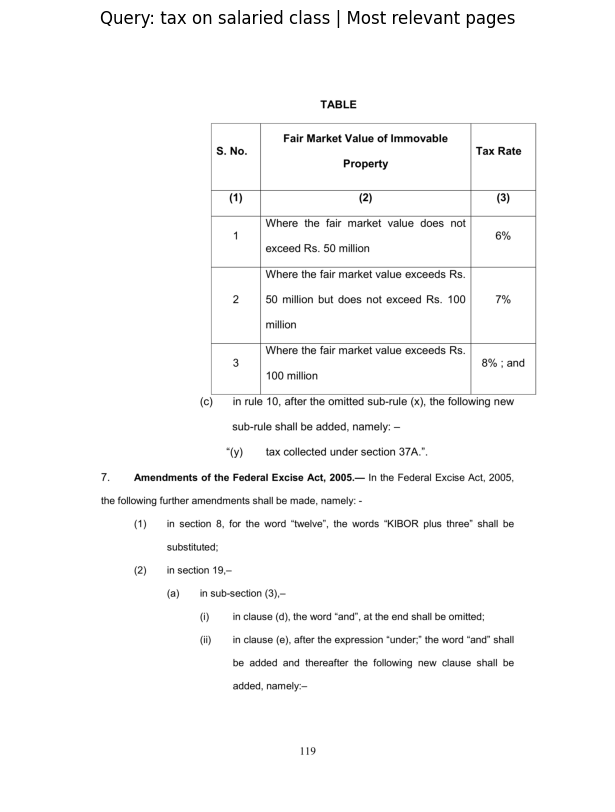

In [44]:
import fitz # pdf reader library (pymupdf)

doc = fitz.open("main.pdf")
page = doc.load_page(160)

#Get the image of the page
img = page.get_pixmap(dpi=300)

doc.close()

# convert the pixmap to a numpy array
img_array = np.frombuffer(img.samples_mv,
                         dtype=np.uint8).reshape((img.h,img.w,img.n))

img_array


#Display the image using Matplolib
import matplotlib.pyplot as plt
plt.figure(figsize=(13,10))
plt.imshow(img_array)
plt.title(f"Query: {query} | Most relevant pages")
plt.axis("off")
plt.show()

### Similarity measures: dot product and cosine similarity

Two of the most common similarity measures between vectors are dot product and cosine similarity.

In essence, closer vectors will have higher scores, further away vectors wil have lower scores.

Vectors have direction (which way is it going?) and magnitude (how long is it?)

In [45]:
import torch

def dot_product(vector1, vector2):
    return torch.dot(vector1,vector2)

def cosine_similarity(vector1, vector2):
    dot_product = torch.dot(vector1,vector2)
    
    # Get Euclidean/ L2 norm
    norm_vector1 = torch.sqrt(torch.sum(vector1**2))
    norm_vector2 = torch.sqrt(torch.sum(vector2**2))
    
    return dot_product / (norm_vector1 * norm_vector2)


# Example vector/tensors

vector1 = torch.tensor([1,2,3], dtype=torch.float32)
vector2 = torch.tensor([1,2,3], dtype=torch.float32)
vector3 = torch.tensor([4,5,6], dtype=torch.float32)
vector4 = torch.tensor([-1,-2,-3], dtype=torch.float32)


# Calculate dot product

print("Dot product between vector1 and vector2: ", dot_product(vector1, vector2))
print("Dot product between vector1 and vector2: ", dot_product(vector1, vector3))
print("Dot product between vector1 and vector2: ", dot_product(vector1, vector4))

# Calculate Cosine similarity
print("Cosine similarity between vector1 and vector2: ", cosine_similarity(vector1, vector2))
print("Cosine similarity between vector1 and vector2: ", cosine_similarity(vector1, vector3))
print("Cosine similarity between vector1 and vector2: ", cosine_similarity(vector1, vector4))

Dot product between vector1 and vector2:  tensor(14.)
Dot product between vector1 and vector2:  tensor(32.)
Dot product between vector1 and vector2:  tensor(-14.)
Cosine similarity between vector1 and vector2:  tensor(1.0000)
Cosine similarity between vector1 and vector2:  tensor(0.9746)
Cosine similarity between vector1 and vector2:  tensor(-1.0000)


## Functionzing Our Semantic Search Pipeline

Lets put all of the steps from above for semantic search into a function or two so we can repeat the workflow.

In [46]:
def retrieve_relevant_resources(query: str,
                                embeddings : torch.tensor,
                                model: SentenceTransformer=embedding_model,
                                n_resources_to_return : int=5,
                                print_time: bool=True):
    """
    Embeds a query with model and returns top k scores and indices from embeddings.
    """
    # Embed the query
    query_embedding = model.encode(query, convert_to_tensor=True)
    
    # Get dot product scores on embeddings
    start_time = timer()
    dot_scores = util.dot_score(query_embedding, embeddings)[0]
    end_time  =   timer()
    
    if print_time:
        print(f"[INFO] Time taken to get scores on ({len(embeddings)}) embeddings : {end_time-start_time:.5f} seconds.")
        
    scores, indices = torch.topk(input=dot_scores,
                                 k=n_resources_to_return)
    
    return scores, indices

def print_top_results_and_scores(query:str,
                                 embeddings: torch.tensor,
                                 pages_and_chunks:list[dict]=pages_and_chunks,
                                 n_resources_to_return: int=5):

    """
    Finds relevant passages given a query and prints them out along with their scores
    """
    
    scores, indices = retrieve_relevant_resources(query=query,
                                                  embeddings=embeddings,
                                                  n_resources_to_return=n_resources_to_return)
    # Loop through zipped together scores and indices from torch.topk
    for score, idx in zip(scores, indices):
        print(f"Score: {score:.4f}")
        print("Text :")
        print_wrapped(pages_and_chunks[idx]["sentence_chunk"])
        print(f"Page number : {pages_and_chunks[idx]['page_number']}")
        print("\n")
    
    
    
    
    
    

In [47]:
query= "?"

# retrieve_relevant_resources(query=query, embeddings=embeddings)
print_top_results_and_scores(query=query, embeddings=embeddings)

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

[INFO] Time taken to get scores on (265) embeddings : 0.00064 seconds.
Score: 0.1965
Text :
All rights reserved.
Page number : 1


Score: 0.1925
Text :
PART - II4
Page number : 174


Score: 0.1866
Text :
(8)Budget RevisedBudget2023-242023-242024-2516,78218,25218,466-200200       400-
1,4331,5441,244-11,12013,70112,404-1,7801,7821,861-2,2491,0242,556Broadcasting
and PublishingRECREATION, CULTURE AND RELIGIONClassificationReligious Af f
airsRECREATION, CULTURE AND RELIGIONRecreation and Sporting Serv
icesAdministration of Inf ormation, Recreation & Culture(Rs in Million)Cultural
Serv ices(9)Budget RevisedBudget2023-242023-242024-2597,098103,684103,781-
4,4685,1285,224-10,77812,29812,624-76,58981,99879,312-180
49726-346359273-3,6982,8444,497-1,0401,0081,124Tertiary Education Af f airs and
Serv ices Subsidiary Serv ices to EducationAdministrationClassificationEDUCATION
AFFAIRS AND SERVICESEducation Services not definable by LevelEDUCATION AFFAIRS
AND SERVICESPre-Primary & Primary Education

## Getting an LLM for Generation

Which LLM should I use ?
* how much hardware VRAM do you have available? if you want to run it locally.

but I am not running it locally instead I am using LLM API.

### Checking local GPU Memory (Optional in this case)

In [48]:
# Get GPU available memory
import torch
gpu_memory_bytes = torch.cuda.get_device_properties(0).total_memory
gpu_memory_gb = round(gpu_memory_bytes / (2**30))
print(f"Available GPU memory: {gpu_memory_gb} GB")

Available GPU memory: 16 GB


### Loading the Model locally

to get the model running we need a few things:
1. A tokenizer- this turns text into numbers ready for the LLM (note: a tokenizer is different from an embedding model)


**Note:** 

we'll check if Flash Attention 2 is available using transformers.utils.is_flash_attn_2_available(). Flash Attention 2 speeds up the attention mechanism in Transformer architecture models (which is what many modern LLMs are based on, including Gemma). So if it's available and the model is supported (not all models support Flash Attention 2), we'll use it. If it's not available, you can install it



we need to use tokenizer before passing text to the LLM.

so as we are using mistral-7B instruct model,its recommend we should use mistral tokenizer.

In [49]:
from kaggle_secrets import UserSecretsClient
user_secrets = UserSecretsClient()
secret_value_0 = user_secrets.get_secret("hf_token")

In [50]:
from huggingface_hub import login
login(token=secret_value_0,add_to_git_credential=True)

Token is valid (permission: write).
Cannot authenticate through git-credential as no helper is defined on your machine.
You might have to re-authenticate when pushing to the Hugging Face Hub.
Run the following command in your terminal in case you want to set the 'store' credential helper as default.

git config --global credential.helper store

Read https://git-scm.com/book/en/v2/Git-Tools-Credential-Storage for more details.
Token has not been saved to git credential helper.
Your token has been saved to /root/.cache/huggingface/token
Login successful


In [51]:
from huggingface_hub import InferenceClient

client = InferenceClient(
    "meta-llama/Meta-Llama-3-8B-Instruct",
    token=secret_value_0,
)

for message in client.chat_completion(
	messages=[{"role": "user", "content": "What is the capital of France?"}],
	max_tokens=500,
	stream=True,
):
    print(message.choices[0].delta.content, end="")


The capital of France is Paris.

In [52]:
gpt_list = [
    "What are the new tax rebates and deductions introduced for senior citizens?",
    "What changes have been made to the income tax slabs and rates for individuals?",
    "Are there any new tax incentives for small and medium-sized enterprises (SMEs)?",
    "What are the new provisions for corporate tax in the budget?",
    "Are there any changes to the capital gains tax regulations?",
    "How has the budget impacted tax rates on dividends?",
    "What modifications have been made to the GST rates for various goods and services?",
    "Are there any new tax exemptions or deductions for startups and entrepreneurs?",
    "What is the impact of the budget on indirect taxes?",
    "Are there any changes to the tax treatment of foreign income?",
    "What new measures have been introduced to combat tax evasion and improve compliance?",
    "Are there any specific tax benefits for investment in renewable energy projects?",
    "How will the budget affect property taxes and real estate transactions?",
    "Are there any new tax policies to support research and development activities?",
    "What changes have been made to the tax structure for high-income earners?",
    "Are there any new tax credits for education and skill development expenses?"

]
manual_list = [
    "What is the tax rates on salaried individual earning more than 120k/month",
    "What is the tax rates on 1300cc used car?",
    "What is the tax rates on the purchase of 1000sqft plot?",
    "What is the sales tax on mobile devices?",
]

query_list = manual_list + gpt_list
query_list

['What is the tax rates on salaried individual earning more than 120k/month',
 'What is the tax rates on 1300cc used car?',
 'What is the tax rates on the purchase of 1000sqft plot?',
 'What is the sales tax on mobile devices?',
 'What are the new tax rebates and deductions introduced for senior citizens?',
 'What changes have been made to the income tax slabs and rates for individuals?',
 'Are there any new tax incentives for small and medium-sized enterprises (SMEs)?',
 'What are the new provisions for corporate tax in the budget?',
 'Are there any changes to the capital gains tax regulations?',
 'How has the budget impacted tax rates on dividends?',
 'What modifications have been made to the GST rates for various goods and services?',
 'Are there any new tax exemptions or deductions for startups and entrepreneurs?',
 'What is the impact of the budget on indirect taxes?',
 'Are there any changes to the tax treatment of foreign income?',
 'What new measures have been introduced to com

In [53]:
import random

query = random.choice(query_list)
print(f"Query : {query}")

# Get jsut the scores and indices of top related results
scores, indices = retrieve_relevant_resources(query=query,
                                              embeddings=embeddings)
scores, indices

Query : What are the new provisions for corporate tax in the budget?


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

[INFO] Time taken to get scores on (265) embeddings : 0.00036 seconds.


(tensor([0.5596, 0.5574, 0.5411, 0.5411, 0.5389]),
 tensor([31,  4,  7, 23, 39]))

### Augmenting our prompt with context items

The concept of augmenting a prompt with context items is also referred as prompt engineering.

we are going to use a couple of prompting techniques:
1. Give clear intructions.
2. Give a few examples of input/output (e.g: given this input, I'd like this output)
3. Give room to think (e.g. create a scratchpad/ "show your working space")/ let's think step by step.

In [54]:
pages_and_chunks[5]

{'page_number': 4,
 'sentence_chunk': 'Budget Brief 2024  | 2© 2024 KPMG Taseer Hadi & Co., a Partnership firm registered in Pakistan and a member firm of the KPMG global organization of independent member firms affiliated with KPMG International Limited, a private English company limited by guarantee.All rights reserved.file the return in response to notice issued by the Commissioner Inland Revenue as under: a)Penalty higher of:─ 0.1% of the tax payable per day; or─ Rs.1,000 per day (not exceeding Rs.10,000 for individuals and Rs.50,000 for all other cases). b)Prosecution for offence punishable with fineup to Rs.25,000 or imprisonment up to two(2) years.•Proposal to penalize with sealing of the shops ofthe Shopkeepers on account of failure to registerunder the Tajir Dost Scheme or similar schemesin the event of non-registration as under:─ Sealing for seven (7) days for first default;and ─ Sealing for twenty (20) days for second default.•Proposal for imposition of penalty onimplementin

In [55]:
# we will create a function
def prompt_formatter(query: str,
                     context_items: list[dict]) -> str:
    
    context= "- " + "\n- ".join([item["sentence_chunk"] for item in context_items])
    base_prompt = """Based on the following context items, please answer the query.
Give yourself room to think by extracting relevant passages from the context before answering the query.
Don't return the thinking, only return the answer.
Make sure your answers are as explanatory as possible.
Use the following examples as reference for the ideal answer style.
\nExample 1:
Query: What changes have been made to the income tax slabs and rates for individuals?
Answer: The Finance Bill proposes to revise the tax rates for salaried individuals. The comparison of existing and proposed rates is as follows:
        For taxable income up to Rs. 600,000, the existing rate and the proposed rate are both 0%.
        For taxable income from Rs. 600,001 to Rs. 1,200,000, the existing rate is 2.5% of the amount exceeding Rs. 600,000, while the proposed rate is 5% of the amount exceeding Rs. 600,000.
        For taxable income from Rs. 1,200,001 to Rs. 2,200,000, the existing rate is Rs. 15,000 plus 12.5% of the amount exceeding Rs. 1,200,000, while the proposed rate is Rs. 30,000 plus 15% of the amount exceeding Rs. 1,200,000.
\nExample 2:
Query: What is the sales tax on mobile devices?
Answer: The Bill proposes to amend Table-II of the Ninth Schedule, which outlines the sales tax rates for cellular mobile phones or satellite phones based on import value per set or equivalent value in rupees for manufacturer supplies. The comparison between existing and proposed rates for each category is as follows:
        Category A: Not exceeding US$ 30 (excluding smartphones)
            Sales tax on CBUs at the time of import or registration (IMEI number by CMOs): Rs. 130 (Old) → 18% (New)
            Sales tax on import in CKD / SKD condition: Rs. 10 (Old) → 18% (New)
            Sales tax on supply of locally manufactured mobile phones in CBU condition in addition to tax under column (4): Rs. 10 (Old) → 18% (New)
        Category B: Not Exceeding US$ 30 (smartphones)
            Sales tax on CBUs at the time of import or registration (IMEI number by CMOs): Rs. 200 (Old) → 18% (New)
            Sales tax on import in CKD / SKD condition: Rs. 10 (Old) → 18% (New) 
\nExample 3:
Query: What modifications have been made to the GST rates for various goods and services?
Answer: The Bill proposes the following amendments
        Sales tax on supplies and imports of plant, machinery, and electricity in tribal areas is proposed to be charged at a reduced rate of 6% for FY 2025 and 12% for FY 2026.
        Sales tax at the rate of 10% is proposed on oil cake and other solid residues, and tractors by placing these items in the Eighth Schedule of the Act.
        Table II – Local supplies only:
            Sales tax at the rate of 10% is proposed on the local supply of vermicelli, sheer mal, bun, and rusk (excluding those sold in bakeries and sweet shops falling in the category of Tier-1 retailers) by placing these items in the Eighth Schedule of the Act.
            Sales tax at the rate of 10% is proposed on the local supply of poultry feed, cattle feed, sunflower seed meal, rape seed meal, and canola seed meal by placing these items in the Eighth Schedule of the Act, with the condition that refund of excess input tax, if any, shall not be admissible.
\nNow use the following context items to answer the user query:
{context}
\nRelevant passages: <extract relevant passages from the context here>
User query:
Answer:"""
    
    base_prompt = base_prompt.format(context=context)
    
    return base_prompt



# Get releveant resources
scores, indices = retrieve_relevant_resources(query=query,
                                             embeddings=embeddings)

# Create a list of context items
context_items = [pages_and_chunks[i] for i in indices]

# Format our prompt
prompt = prompt_formatter(query=query,
                         context_items=context_items)

print(prompt)

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

[INFO] Time taken to get scores on (265) embeddings : 0.00080 seconds.
Based on the following context items, please answer the query.
Give yourself room to think by extracting relevant passages from the context before answering the query.
Don't return the thinking, only return the answer.
Make sure your answers are as explanatory as possible.
Use the following examples as reference for the ideal answer style.

Example 1:
Query: What changes have been made to the income tax slabs and rates for individuals?
Answer: The Finance Bill proposes to revise the tax rates for salaried individuals. The comparison of existing and proposed rates is as follows:
        For taxable income up to Rs. 600,000, the existing rate and the proposed rate are both 0%.
        For taxable income from Rs. 600,001 to Rs. 1,200,000, the existing rate is 2.5% of the amount exceeding Rs. 600,000, while the proposed rate is 5% of the amount exceeding Rs. 600,000.
        For taxable income from Rs. 1,200,001 to Rs. 

In [56]:
response = client.chat_completion(
	messages=[{"role": "user", "content": prompt}],
	max_tokens=500,
    temperature=0.7,
	stream=True,
)
output = [message.choices[0].delta.content for message in response]
output_text = ''.join(output)
print(f"Query: {query}")
print(f"RAG Answer:\n {output_text.replace(prompt, '')}")

Query: What are the new provisions for corporate tax in the budget?
RAG Answer:
 The user query is not provided. Please provide the query, and I'll extract relevant passages from the context and answer the query accordingly.


In [57]:
"""Based on the following context items, please answer the query.
Give yourself room to think by extracting relevant passages from the context before answering the query.
Don't return the thinking, only return the answer.
Make sure your answers are as explanatory as possible.
Use the following examples as reference for the ideal answer style.
\nExample 1:
Query: What changes have been made to the income tax slabs and rates for individuals?
Answer: The Finance Bill proposes to revise the tax rates for salaried individuals. The comparison of existing and proposed rates is as follows:
        For taxable income up to Rs. 600,000, the existing rate and the proposed rate are both 0%.
        For taxable income from Rs. 600,001 to Rs. 1,200,000, the existing rate is 2.5% of the amount exceeding Rs. 600,000, while the proposed rate is 5% of the amount exceeding Rs. 600,000.
        For taxable income from Rs. 1,200,001 to Rs. 2,200,000, the existing rate is Rs. 15,000 plus 12.5% of the amount exceeding Rs. 1,200,000, while the proposed rate is Rs. 30,000 plus 15% of the amount exceeding Rs. 1,200,000.
\nExample 2:
Query: What is the sales tax on mobile devices?
Answer: The Bill proposes to amend Table-II of the Ninth Schedule, which outlines the sales tax rates for cellular mobile phones or satellite phones based on import value per set or equivalent value in rupees for manufacturer supplies. The comparison between existing and proposed rates for each category is as follows:
        Category A: Not exceeding US$ 30 (excluding smartphones)
            Sales tax on CBUs at the time of import or registration (IMEI number by CMOs): Rs. 130 (Old) → 18% (New)
            Sales tax on import in CKD / SKD condition: Rs. 10 (Old) → 18% (New)
            Sales tax on supply of locally manufactured mobile phones in CBU condition in addition to tax under column (4): Rs. 10 (Old) → 18% (New)
        Category B: Not Exceeding US$ 30 (smartphones)
            Sales tax on CBUs at the time of import or registration (IMEI number by CMOs): Rs. 200 (Old) → 18% (New)
            Sales tax on import in CKD / SKD condition: Rs. 10 (Old) → 18% (New) 
\nExample 3:
Query: What modifications have been made to the GST rates for various goods and services?
Answer: The Bill proposes the following amendments
        Sales tax on supplies and imports of plant, machinery, and electricity in tribal areas is proposed to be charged at a reduced rate of 6% for FY 2025 and 12% for FY 2026.
        Sales tax at the rate of 10% is proposed on oil cake and other solid residues, and tractors by placing these items in the Eighth Schedule of the Act.
        Table II – Local supplies only:
            Sales tax at the rate of 10% is proposed on the local supply of vermicelli, sheer mal, bun, and rusk (excluding those sold in bakeries and sweet shops falling in the category of Tier-1 retailers) by placing these items in the Eighth Schedule of the Act.
            Sales tax at the rate of 10% is proposed on the local supply of poultry feed, cattle feed, sunflower seed meal, rape seed meal, and canola seed meal by placing these items in the Eighth Schedule of the Act, with the condition that refund of excess input tax, if any, shall not be admissible.
\nNow use the following context items to answer the user query:
{context}
\nRelevant passages: <extract relevant passages from the context here>
User query: {query}
Answer:"""

"Based on the following context items, please answer the query.\nGive yourself room to think by extracting relevant passages from the context before answering the query.\nDon't return the thinking, only return the answer.\nMake sure your answers are as explanatory as possible.\nUse the following examples as reference for the ideal answer style.\n\nExample 1:\nQuery: What changes have been made to the income tax slabs and rates for individuals?\nAnswer: The Finance Bill proposes to revise the tax rates for salaried individuals. The comparison of existing and proposed rates is as follows:\n        For taxable income up to Rs. 600,000, the existing rate and the proposed rate are both 0%.\n        For taxable income from Rs. 600,001 to Rs. 1,200,000, the existing rate is 2.5% of the amount exceeding Rs. 600,000, while the proposed rate is 5% of the amount exceeding Rs. 600,000.\n        For taxable income from Rs. 1,200,001 to Rs. 2,200,000, the existing rate is Rs. 15,000 plus 12.5% of th

### Functionize LLM answering feature

In [58]:
def ask(query: str,
        temprature:float=0.7,
        max_new_tokens: int=256,
        format_answer_text=True,
        return_answer_only=True):
    """
    Takes a query, finds relevant resources/context and generates an answer to the query to the query based on the relevant resources.
    """
    
    # Get the scores and indices of top related results
    scores, indices = retrieve_relevant_resources(query=query,
                                                  embeddings=embeddings)
    
    # Create a list of context items
    context_items = [pages_and_chunks[i] for i in indices]
    
    # Add score to context item
    for i, item in enumerate(context_items):
        item['score'] = scores[i].cpu()
        
    # AUGMENTATION
    # Create the prompt and format it with context items
    prompt = prompt_formatter(query=query,
                              context_items=context_items)
    
    # GENERATION
    response = client.chat_completion(
	messages=[{"role": "user", "content": prompt}],
	max_tokens=max_new_tokens,
    temperature=temprature
    )
    
    for message in response['choices']:
        output = message['message']['content']
    output_text = ''.join(output)
    
    # Replace special tokens and unnecessary help message
    if format_answer_text:
        output_text = output_text.replace(prompt, "").replace("<bos>", "").replace("<eos>", "").replace("Sure, here is the answer to the user query:\n\n", "")
    
    # Only return the answer without the context items
    if return_answer_only:
        return output_text

    return output_text, context_items
    

In [59]:
query = random.choice(query_list)
print(f"Query: {query}")
ask(query=query)

Query: Are there any new tax policies to support research and development activities?


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

[INFO] Time taken to get scores on (265) embeddings : 0.00025 seconds.


/opt/conda/lib/python3.10/site-packages/huggingface_hub/inference/_generated/types/base.py:139: FutureWarning: Accessing 'ChatCompletionOutput' values through dict is deprecated and will be removed from version '0.25'. Use dataclass attributes instead.
  warnings.warn(


'Based on the provided context, I will extract the relevant passages and answer the user query.\n\nRelevant passages:\n\n* Budget Brief 2024  | 17   © 2024 KPMG Taseer Hadi & Co., a Partnership firm registered in Pakistan and a member firm of the KPMG global organization of independent member firms affiliated with KPMG International Limited, a private English company limited by guarantee.All rights reserved. S. No.Amount Tax Rate 1 Upto Rs.50 million 3% 2 Exceeding Rs.50 million but does not exceed Rs.100 million 3.5% 3 Exceeding Rs.100 million 4%\n* Budget Brief 2024  | 14  © 2024 KPMG Taseer Hadi & Co., a Partnership firm registered in Pakistan and a member firm of the KPMG global organization of independent member firms affiliated with KPMG International Limited, a private English company limited by guarantee.All rights reserved. Gross Salary (Rs.)Tax Liability Tax incidence Existing (Rs.)Proposed (Rs.) (reduction) / increase (Rs.) (reduction) / increase (%) 600,000 0 0 0 0 1,200,'